# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [118]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold
from ipywidgets import *
from IPython.display import display
%matplotlib inline

In [2]:
# Load the data into a DataFrame
sales = pd.read_csv('../assets/datasets/Iowa_Liquor_sales_sample_10pct.csv')

In [3]:
# Converting dates
sales['Date'] =  pd.to_datetime(sales['Date'], format = '%m/%d/%Y')

# Removing redundant columns
# sales.drop('Volume Sold (Gallons)', axis = 1, inplace = True)

# Removing $ and convert to float
sales['State Bottle Cost'].replace('\$', '', regex = True, inplace = True)
sales['State Bottle Cost'] = sales['State Bottle Cost'].astype(float, copy = True)

sales['State Bottle Retail'].replace('\$', '', regex = True, inplace = True)
sales['State Bottle Retail'] = sales['State Bottle Retail'].astype(float, copy = True)

sales['Sale (Dollars)'].replace('\$', '', regex = True, inplace = True)
sales['Sale (Dollars)'] = sales['Sale (Dollars)'].astype(float, copy = True)

# Creating a profit column
sales['Profit'] = (sales['State Bottle Retail'] - sales['State Bottle Cost']) * sales['Bottles Sold']

sales['Month'] = sales.Date.dt.month

sales['Year'] = sales.Date.dt.year

# sales.Year = sales['Year'].apply(lambda x: x - 2015)

# Creating a price per liter column
sales['Price Per Liter'] = sales['State Bottle Retail']/(sales['Bottle Volume (ml)']/1000)
sales['Price Per Liter'] = sales['Price Per Liter'].round(2)

# Fixing Zip Code column
sales['Zip Code'].replace('712-2', '51529', inplace = True)
sales['Zip Code'] = sales['Zip Code'].astype(int, copy = True)

# Dropping NaN values
sales.dropna(axis = 0, how = 'any', inplace = True)

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269258 entries, 0 to 270954
Data columns (total 22 columns):
Date                     269258 non-null datetime64[ns]
Store Number             269258 non-null int64
City                     269258 non-null object
Zip Code                 269258 non-null int64
County Number            269258 non-null float64
County                   269258 non-null object
Category                 269258 non-null float64
Category Name            269258 non-null object
Vendor Number            269258 non-null int64
Item Number              269258 non-null int64
Item Description         269258 non-null object
Bottle Volume (ml)       269258 non-null int64
State Bottle Cost        269258 non-null float64
State Bottle Retail      269258 non-null float64
Bottles Sold             269258 non-null int64
Sale (Dollars)           269258 non-null float64
Volume Sold (Liters)     269258 non-null float64
Volume Sold (Gallons)    269258 non-null float64
Profit          

In [417]:
# DONT RUN THIS IT TAKES WAY TOO LONG
# Using ffill to fill in nans 
# for group_label, group_sales in sales.groupby(["Zip Code", "Item Number"]): 
#     mask = (sales['Zip Code'] == group_label[0]) & (sales["Item Number"] == group_label[1])
#     sales[mask] = sales[mask].sort(["County", "Category"]).ffill()

# for group_label, group_df in df.groupby("Zip Code"):
#     df[df["Zip Code"] == group_label] = df[df["Zip Code"] == group_label].sort("County Number").ffill()
    
# df.interpolate(method = 'linear', inplace = True, limit_direction = 'both')

NameError: name 'df' is not defined

In [6]:
# Deleting liquors that were only sold 2 times
beer_mask = sales['Category Name'] == 'HIGH PROOF BEER - AMERICAN'

sales[beer_mask]

sales.drop(sales[beer_mask].index, axis = 0, inplace = True)

In [7]:
sales.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Profit,Month,Year,Price Per Liter
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,...,4.50,6.75,12,81.00,9.0,2.38,27.00,11,2015,9.00
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,...,13.75,20.63,2,41.26,1.5,0.40,13.76,3,2016,27.51
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,...,12.59,18.89,24,453.36,24.0,6.34,151.20,2,2016,18.89
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,...,9.50,14.25,6,85.50,10.5,2.77,28.50,2,2016,8.14
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,...,7.20,10.80,12,129.60,21.0,5.55,43.20,8,2015,6.17


In [8]:
# Generalizing categories

for x in sales['Category Name']:
    if 'WHISK' in str(x):
        sales['Category Name'].replace(x, 'Whisky', inplace = True)
    elif 'BRAND' in str(x):
        sales['Category Name'].replace(x, 'Brandy', inplace = True)
    elif 'COCKTAIL' in str(x):
        sales['Category Name'].replace(x, 'Cocktail', inplace = True)
    elif 'VODKA' in str(x):
        sales['Category Name'].replace(x, 'Vodka', inplace = True)
    elif 'GIN' in str(x):
        sales['Category Name'].replace(x, 'Gin', inplace = True)
    elif 'SCHNAP' in str(x):
        sales['Category Name'].replace(x, 'Brandy', inplace = True)
    elif 'LIQUEUR' in str(x):
        sales['Category Name'].replace(x, 'Liqueur', inplace = True)
    elif 'TRIPLE SEC' in str(x):
        sales['Category Name'].replace(x, 'Liqueur', inplace = True)
    elif 'ANISETTE' in str(x):
        sales['Category Name'].replace(x, 'Liqueur', inplace = True)
    elif 'TEQUILA' in str(x):
        sales['Category Name'].replace(x, 'Tequila', inplace = True)
    elif 'BOURBON' in str(x):
        sales['Category Name'].replace(x, 'Whisky', inplace = True)
    elif 'SCOTCH' in str(x):
        sales['Category Name'].replace(x, 'Whisky', inplace = True)
    elif 'RUM' in str(x):
        sales['Category Name'].replace(x, 'Rum', inplace = True)
    elif 'AMARETTO' in str(x):
        sales['Category Name'].replace(x, 'Amaretto', inplace = True)
    elif 'ROCK & RYE' in str(x):
        sales['Category Name'].replace(x, 'Whisky', inplace = True)
    elif 'CREME DE' in str(x):
        sales['Category Name'].replace(x, 'Mixer', inplace = True)
    elif 'AMERICAN ALCOHOL' in str(x):
        sales['Category Name'].replace(x, 'Misc.', inplace = True)
    elif 'DECANTER' in str(x):
        sales['Category Name'].replace(x, 'Decanter', inplace = True)
    elif 'SPECIALTY' in str(x):
        sales['Category Name'].replace(x, 'Specialties', inplace = True)

sales['Category Name'].unique()

array(['Brandy', 'Whisky', 'Cocktail', 'Vodka', 'Gin', 'Specialties',
       'Tequila', 'Liqueur', 'Rum', 'Amaretto', 'Misc.', 'Decanter',
       'Mixer'], dtype=object)

In [222]:
# Creating a new column that holds a number to represent each category.
cats = sorted(sales['Category Name'].unique())
cats_list = list(enumerate(cats, start = 1))

lt = []
for cats in sales['Category Name']:
    for x in cats_list:
        if x[1] == cats:
            lt.append(x[0])

sales['Category Number'] = lt

sales.head()

print sorted(sales['Category Name'].unique())

['Amaretto', 'Brandy', 'Cocktail', 'Decanter', 'Gin', 'Liqueur', 'Misc.', 'Mixer', 'Rum', 'Specialties', 'Tequila', 'Vodka', 'Whisky']


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

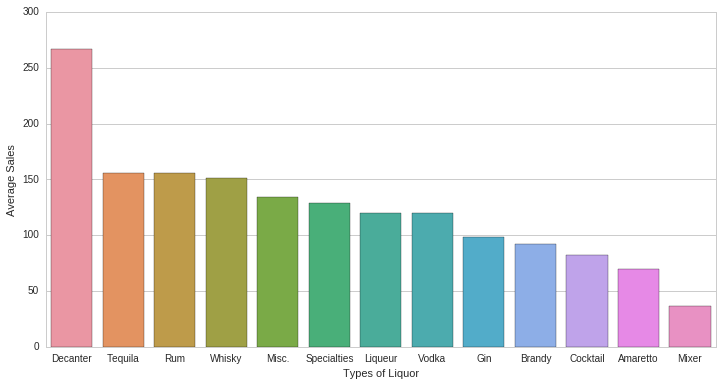

In [220]:
# Seeing which liquor makes the most money on average
avg_liquor_profit = sales.groupby('Category Name')['Sale (Dollars)'].mean()

avg_liquor_profit = pd.DataFrame(avg_liquor_profit).reset_index().sort_values(by = 'Sale (Dollars)', ascending = False)

sns.set(rc = {"figure.figsize": (12, 6)}, style = 'whitegrid')
ax = sns.barplot(x = 'Category Name', y = 'Sale (Dollars)', data = avg_liquor_profit)

ax.set(xlabel = 'Types of Liquor', ylabel = 'Average Sales')

plt.show()

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

- It seems like liquor plays a big part in how much money a store makes so I'm going to try to use each store's most profitable liquor as one of my predictors.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [12]:
# Determine which stores were open all of 2015
# Find the first and last sales date.
mask1 = sales.Year == 2015

first_sale_date = sales[mask1].groupby(['Store Number'])['Date'].min()
last_sale_date = sales[mask1].groupby(['Store Number'])['Date'].max()
# Filter out stores that opened or closed throughout the year

first_sale_df = pd.DataFrame(first_sale_date).reset_index()
last_sale_df = pd.DataFrame(last_sale_date).reset_index()

mask2 = [first_sale_df.Date[i].month == 1 for i in range(len(first_sale_df))]
mask3 = [last_sale_df.Date[i].month == 12 for i in range(len(first_sale_df))]

jan_stores = first_sale_df[mask2]['Store Number']
dec_stores = last_sale_df[mask3]['Store Number']

full_year_stores_mask = jan_stores.isin(dec_stores)
full_year_stores = jan_stores[full_year_stores_mask]

final_mask = sales['Store Number'].isin(full_year_stores)
sales_both = sales[final_mask]

sales_both.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Profit,Month,Year,Price Per Liter,Category Number
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,Brandy,55,54436,...,6.75,12,81.00,9.0,2.38,27.00,11,2015,9.00,2
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,Whisky,395,27605,...,20.63,2,41.26,1.5,0.40,13.76,3,2016,27.51,13
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,Whisky,65,19067,...,18.89,24,453.36,24.0,6.34,151.20,2,2016,18.89,13
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,Cocktail,395,59154,...,14.25,6,85.50,10.5,2.77,28.50,2,2016,8.14,3
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,Vodka,297,35918,...,10.80,12,129.60,21.0,5.55,43.20,8,2015,6.17,12


In [74]:
q1_15_mask = (sales_both.Month <= 3) & (sales_both.Month >= 1) & (sales_both.Year == 2015)
q1_16_mask = (sales_both.Month <= 3) & (sales_both.Month >= 1) & (sales_both.Year == 2016)
all_15_mask = sales_both.Year == 2015
all_16_mask = sales_both.Year == 2016

q1_15_stores = sales_both[q1_15_mask]
q1_16_stores = sales_both[q1_16_mask]
all_15_stores = sales_both[all_15_mask]
all_16_stores = sales_both[all_16_mask]

In [75]:
# Store Number and respective County Numbers
counties = sales_both.groupby(['Store Number', 'County Number'])
store_cats = counties['Store Number', 'County Number'].head(1).sort_values(by = 'Store Number', ascending = True)

In [78]:
# Creating a subset with the average profit for each category for 2015
avg_profit_cats_15 = all_15_stores.groupby(['Store Number', 'Category Number'])['Profit'].mean()
avg_profit_cats_15 = pd.DataFrame(avg_profit_cats_15).reset_index()

# Selecting the category with the max average profit for each store for 2015
max_cats_15 = avg_profit_cats_15.loc[avg_profit_cats_15.reset_index().groupby(['Store Number'])['Profit'].idxmax()]
max_cats_15.drop('Profit', axis = 1, inplace = True)
max_cats_15.head()

,Store Number,Category Number
7,2106,9
17,2113,9
28,2130,9
39,2152,9
48,2178,9


In [16]:
# Creating a subset with the average profit for each category for 2016
avg_profit_cats_16 = all_16_stores.groupby(['Store Number', 'Category Number'])['Profit'].mean()
avg_profit_cats_16 = pd.DataFrame(avg_profit_cats_16).reset_index()

# Selecting the category with the max average profit for each store for 2016
max_cats_16 = avg_profit_cats_16.loc[avg_profit_cats_16.reset_index().groupby(['Store Number'])['Profit'].idxmax()]
max_cats_16.drop('Profit', axis = 1, inplace = True)
max_cats_16.head()

,Store Number,Category Number
6,2106,9
17,2113,13
24,2130,12
30,2152,13
36,2178,7


In [17]:
# Creating a subset with the average profit for each price per liter for 2016
avg_ppl_16 = all_16_stores.groupby(['Store Number'])['Price Per Liter'].mean()
avg_ppl_16 = pd.DataFrame(avg_ppl_16).reset_index()
avg_ppl_16['Price Per Liter'] = avg_ppl_16['Price Per Liter'].round(2)

avg_ppl_16.head()

,Store Number,Price Per Liter
0,2106,17.97
1,2113,17.48
2,2130,17.45
3,2152,12.49
4,2178,15.10


In [18]:
# Creating a subset with the average profit for each price per liter for 2015
avg_ppl_15 = all_15_stores.groupby(['Store Number'])['Price Per Liter'].mean()
avg_ppl_15 = pd.DataFrame(avg_ppl_15).reset_index()
avg_ppl_15['Price Per Liter'] = avg_ppl_15['Price Per Liter'].round(2)

avg_ppl_15.head()

,Store Number,Price Per Liter
0,2106,17.85
1,2113,18.50
2,2130,16.82
3,2152,13.02
4,2178,16.06


In [100]:
# Q1 2015 total profits per store
q1_15_profits = q1_15_stores.groupby(['Store Number'])['Profit', 'Sale (Dollars)'].sum()
q1_15_profits = pd.DataFrame(q1_15_profits).reset_index().sort_values(by = 'Store Number', ascending = True)

# Q1 2016 total profits per store
q1_16_profits = q1_16_stores.groupby(['Store Number'])['Profit', 'Sale (Dollars)'].sum()
q1_16_profits = pd.DataFrame(q1_16_profits).reset_index().sort_values(by = 'Store Number', ascending = True)

# All 2015 total profits per store
all_15_profits = all_15_stores.groupby(['Store Number'])['Profit', 'Sale (Dollars)'].sum()
all_15_profits = pd.DataFrame(all_15_profits).reset_index().sort_values(by = 'Store Number', ascending = True)

In [101]:
# Creating dataframes per quarter of 2015 to calculate growth rate and predict 2016

# Creating masks for other 3 quarters
q2_15_mask = (sales_both.Year == 2015) & (sales_both.Month >= 4) & (sales_both.Month <= 6)
q3_15_mask = (sales_both.Year == 2015) & (sales_both.Month >= 7) & (sales_both.Month <= 9)
q4_15_mask = (sales_both.Year == 2015) & (sales_both.Month >= 10) & (sales_both.Month <= 12)

# Grouping each quarter
q2_15_profit = sales_both[q2_15_mask].groupby(['Store Number'])['Profit', 'Sale (Dollars)'].sum()
q3_15_profit = sales_both[q3_15_mask].groupby(['Store Number'])['Profit', 'Sale (Dollars)'].sum()
q4_15_profit = sales_both[q4_15_mask].groupby(['Store Number'])['Profit', 'Sale (Dollars)'].sum()

# Turning groupby df into a df
q2_15_profit = pd.DataFrame(q2_15_profit).reset_index()
q3_15_profit = pd.DataFrame(q3_15_profit).reset_index()
q4_15_profit = pd.DataFrame(q4_15_profit).reset_index()

# Renaming column titles before merging dfs
q2_15_profit = q2_15_profit.rename(columns = {'Profit':'Q2 Profit','Sale (Dollars)': 'Q2 Sales'})
q3_15_profit = q3_15_profit.rename(columns = {'Profit':'Q3 Profit','Sale (Dollars)': 'Q3 Sales'})
q4_15_profit = q4_15_profit.rename(columns = {'Profit':'Q4 Profit','Sale (Dollars)': 'Q4 Sales'})

# Merging quarterly dataframes
quarterly_profit = pd.merge(pd.merge(q2_15_profit, q3_15_profit, on = 'Store Number'),
                            q4_15_profit, on = 'Store Number')
quarter_preds = pd.merge(pd.merge(q1_15_profits, quarterly_profit, on = 'Store Number'), q1_16_profits, on = 'Store Number')

# Renaming q1 since it is called profits
quarter_preds = quarter_preds.rename(columns = {'Profit_x': 'Q1 Profit','Sale (Dollars)_x':'Q1 Sales',
                                               'Profit_y': 'Q1-16 Profit','Sale (Dollars)_y':'Q1-16 Sales'})

quarter_preds.head()

,Store Number,Q1 Profit,Q1 Sales,Q2 Profit,Q2 Sales,Q3 Profit,Q3 Sales,Q4 Profit,Q4 Sales,Q1-16 Profit,Q1-16 Sales
0,2106,13108.37,39287.29,10420.43,31173.46,12787.25,38324.77,12426.15,37253.18,10174.68,30478.75
1,2113,944.72,2833.25,664.99,1994.30,704.77,2113.56,794.56,2369.11,693.49,2065.90
2,2130,8108.68,24272.57,11689.39,35038.09,8204.60,24605.88,9226.65,27667.37,9288.29,27856.11
3,2152,668.60,2003.46,470.86,1398.92,752.36,2246.70,695.71,2072.00,304.08,904.66
4,2178,1961.28,5856.41,2372.80,6986.33,1890.11,5668.15,1941.51,5813.29,1868.76,5588.50


In [102]:
# Growth rate calculator
def growth_rate(df, start, end):
    return ((df[end] - df[start])/df[start])

# Creating new columns for each growth rate by profit
quarter_preds['Q2-16 Predicted Profit'] = quarter_preds['Q1-16 Profit'] + (
    quarter_preds['Q1-16 Profit']*(growth_rate(quarter_preds, 'Q1 Profit', 'Q2 Profit')))

quarter_preds['Q3-16 Predicted Profit'] = quarter_preds['Q2-16 Predicted Profit'] + (
    quarter_preds['Q2-16 Predicted Profit']*(growth_rate(quarter_preds, 'Q2 Profit', 'Q3 Profit')))

quarter_preds['Q4-16 Predicted Profit'] = quarter_preds['Q3-16 Predicted Profit'] + (
    quarter_preds['Q3-16 Predicted Profit']*(growth_rate(quarter_preds, 'Q3 Profit', 'Q4 Profit')))

# Creating new columns for each growth rate by sales
quarter_preds['Q2-16 Predicted Sales'] = quarter_preds['Q1-16 Sales'] + (
    quarter_preds['Q1-16 Sales']*(growth_rate(quarter_preds, 'Q1 Sales', 'Q2 Sales')))

quarter_preds['Q3-16 Predicted Sales'] = quarter_preds['Q2-16 Predicted Sales'] + (
    quarter_preds['Q2-16 Predicted Sales']*(growth_rate(quarter_preds, 'Q2 Sales', 'Q3 Sales')))

quarter_preds['Q4-16 Predicted Sales'] = quarter_preds['Q3-16 Predicted Sales'] + (
    quarter_preds['Q3-16 Predicted Sales']*(growth_rate(quarter_preds, 'Q3 Sales', 'Q4 Sales')))

quarter_preds = quarter_preds.round(2)

quarter_preds.head()

,Store Number,Q1 Profit,Q1 Sales,Q2 Profit,Q2 Sales,Q3 Profit,Q3 Sales,Q4 Profit,Q4 Sales,Q1-16 Profit,Q1-16 Sales,Q2-16 Predicted Profit,Q3-16 Predicted Profit,Q4-16 Predicted Profit,Q2-16 Predicted Sales,Q3-16 Predicted Sales,Q4-16 Predicted Sales
0,2106,13108.37,39287.29,10420.43,31173.46,12787.25,38324.77,12426.15,37253.18,10174.68,30478.75,8088.31,9925.43,9645.14,24184.11,29732.04,28900.70
1,2113,944.72,2833.25,664.99,1994.30,704.77,2113.56,794.56,2369.11,693.49,2065.90,488.15,517.35,583.26,1454.17,1541.13,1727.47
2,2130,8108.68,24272.57,11689.39,35038.09,8204.60,24605.88,9226.65,27667.37,9288.29,27856.11,13389.90,9398.16,10568.90,40211.02,28238.63,31752.11
3,2152,668.60,2003.46,470.86,1398.92,752.36,2246.70,695.71,2072.00,304.08,904.66,214.15,342.17,316.41,631.68,1014.49,935.61
4,2178,1961.28,5856.41,2372.80,6986.33,1890.11,5668.15,1941.51,5813.29,1868.76,5588.50,2260.87,1800.95,1849.92,6666.73,5408.85,5547.35


# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [103]:
total_preds = quarter_preds.copy()

# Creating a sum of the total 2015 sales, 2016 predicted sales, and predicted profits
total_preds['2016 Predicted Profit'] = total_preds['Q1-16 Profit'] + total_preds['Q2-16 Predicted Profit'] + total_preds['Q3-16 Predicted Profit'] + total_preds['Q4-16 Predicted Profit']
total_preds['2016 Predicted Sales'] = total_preds['Q1-16 Sales'] + total_preds['Q2-16 Predicted Sales'] + total_preds['Q3-16 Predicted Sales'] + total_preds['Q4-16 Predicted Sales']

# Dropping the unnecessary columns
total_preds.drop(['Q1-16 Profit','Q2-16 Predicted Profit','Q3-16 Predicted Profit','Q4-16 Predicted Profit'], axis = 1, inplace = True)
total_preds.drop(['Q1-16 Sales','Q2-16 Predicted Sales','Q3-16 Predicted Sales','Q4-16 Predicted Sales'], axis = 1, inplace = True)
total_preds.drop(['Q1 Sales','Q2 Sales','Q3 Sales','Q4 Sales'], axis = 1, inplace = True)
total_preds.drop(['Q1 Profit','Q2 Profit','Q3 Profit','Q4 Profit'], axis = 1, inplace = True)

total_preds.head()

,Store Number,2016 Predicted Profit,2016 Predicted Sales
0,2106,37833.56,113295.60
1,2113,2282.25,6788.67
2,2130,42645.25,128057.87
3,2152,1176.81,3486.44
4,2178,7780.50,23211.43


In [107]:
# Merging all above subsets into one subset containing all predictor and target variables
subset1 = pd.merge(pd.merge(q1_15_profits, q1_16_profits, on = 'Store Number'), all_15_profits, on = 'Store Number')

subset2 = pd.merge(pd.merge(avg_ppl_15, avg_ppl_16, on = 'Store Number'), subset1, on = 'Store Number')

subset3 = pd.merge(pd.merge(max_cats_15, max_cats_16, on = 'Store Number'), subset2, on = 'Store Number')

subset4 = pd.merge(pd.merge(store_cats, subset3, on = 'Store Number'), total_preds, on = 'Store Number')

model_df = subset4.rename(columns = {'Profit_x': 'Q12015 Profit', 'Profit_y': 'Q12016 Profit', 'Profit': '2015 Profit',
                                   'Category Number_x': '2015 Most Profitable Liquor', 
                                   'Category Number_y': '2016 Most Profitable Liquor',
                                   'Price Per Liter_x': '2015 Avg Price Per Liter',
                                   'Price Per Liter_y': '2016 Avg Price Per Liter',
                                    'Sale (Dollars)': '2015 Sales', 'Sale (Dollars)_x': 'Q12015 Sales',
                                    'Sale (Dollars)_y': 'Q12016 Sales'})

model_df.head()

,Store Number,County Number,2015 Most Profitable Liquor,2016 Most Profitable Liquor,2015 Avg Price Per Liter,2016 Avg Price Per Liter,Q12015 Profit,Q12015 Sales,Q12016 Profit,Q12016 Sales,2015 Profit,2015 Sales,2016 Predicted Profit,2016 Predicted Sales
0,2106,7.0,9,9,17.85,17.97,13108.37,39287.29,10174.68,30478.75,48742.20,146038.70,37833.56,113295.60
1,2113,94.0,9,13,18.50,17.48,944.72,2833.25,693.49,2065.90,3109.04,9310.22,2282.25,6788.67
2,2130,7.0,9,12,16.82,17.45,8108.68,24272.57,9288.29,27856.11,37229.32,111583.91,42645.25,128057.87
3,2152,17.0,9,13,13.02,12.49,668.60,2003.46,304.08,904.66,2587.53,7721.08,1176.81,3486.44
4,2178,3.0,9,7,16.06,15.10,1961.28,5856.41,1868.76,5588.50,8165.70,24324.18,7780.50,23211.43


In [109]:
# Normalizing our above subset
model_copy = model_df.copy()

cols = [x for x in model_copy.columns if x != '2015 Profit' and x != 'Q12016 Profit' and x != 'County Number' and 
        x != '2015 Most Profitable Liquor' and x != '2016 Most Profitable Liquor' and x != 'Store Number' and
        x != '2016 Predicted Profit' and x != '2016 Predicted Sales' and x != 'Q12016 Sales' and x != '2015 Sales']

model_copy.ix[:, cols] = (model_copy.ix[:, cols] - model_copy.ix[:, cols].mean()) / model_copy.ix[:, cols].std()

model_copy.head()

,Store Number,County Number,2015 Most Profitable Liquor,2016 Most Profitable Liquor,2015 Avg Price Per Liter,2016 Avg Price Per Liter,Q12015 Profit,Q12015 Sales,Q12016 Profit,Q12016 Sales,2015 Profit,2015 Sales,2016 Predicted Profit,2016 Predicted Sales
0,2106,7.0,9,9,0.216476,0.175466,2.671994,2.675791,10174.68,30478.75,48742.20,146038.70,37833.56,113295.60
1,2113,94.0,9,13,0.388927,0.074389,-0.221082,-0.219952,693.49,2065.90,3109.04,9310.22,2282.25,6788.67
2,2130,7.0,9,12,-0.056793,0.068200,1.482837,1.483090,9288.29,27856.11,37229.32,111583.91,42645.25,128057.87
3,2152,17.0,9,13,-1.064967,-0.954952,-0.286756,-0.285867,304.08,904.66,2587.53,7721.08,1176.81,3486.44
4,2178,3.0,9,7,-0.258427,-0.416559,0.020703,0.020194,1868.76,5588.50,8165.70,24324.18,7780.50,23211.43


# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [231]:
# Using lasso to determine which predictors to use
preds = ['2015 Avg Price Per Liter']

#Can't use categorical values because they don't end up indicating quantitative values. 
#Can't use a predictor that was used in the calculations of what you're trying to predict

x = model_copy[preds]
y = model_copy['2015 Sales']

lmodel = Lasso(alpha = 1)
lmodel.fit(x ,y)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [232]:
# When coef is 0 the predictor it matches to above is 'zeroed' out
lmodel.coef_

array([ 9870.558958])

In [233]:
# Our lasso regression model's score
print lmodel.score(x, y)

0.0298825351143


In [234]:
# Using train-test-split to cross validate whether this model is good.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
lmodel.fit(x_train, y_train)
lactual = y_test
lpred = lmodel.predict(x_test)
print lmodel.score(x_test, y_test)
print lmodel.score(x_train, y_train)

0.0420373442488
0.0262876174756


In [245]:
# Making our linear regression model for 2015 data
lrmodel = LinearRegression()
lrmodel.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [246]:
# Our linear regression model's score
lrmodel.score(x, y)

0.02988253542150654

In [247]:
# Fitting our 2015 model
lrmodel.fit(x_train, y_train)
lractual = y_test
lrpred = lrmodel.predict(x_test)
print lrmodel.score(x_test, y_test)
print lrmodel.score(x_train, y_train)

0.0420389395293
0.0262876176983


In [248]:
# Using our predictors from 2015 to predict 2016 sales
preds16 = ['Q12015 Sales', '2015 Avg Price Per Liter']

x16 = model_copy[preds16]
y16 = model_copy['Q12016 Sales']

# Creating our lasso model and fitting it to our 2015 data
lmodel16 = Lasso(alpha = 1)
lmodel16.fit(x16, y16)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [249]:
lmodel16.coef_

array([ 12092.64234966,    -35.23066447])

In [250]:
lmodel16.score(x16, y16)

0.90257479345863401

In [251]:
# Using train-test-split to cross validate whether this model is good.
x16_train, x16_test, y16_train, y16_test = train_test_split(x16, y16, test_size = 0.3)
lmodel16.fit(x16_train, y16_train)
lactual16 = y16_test
lpred16 = lmodel16.predict(x16_test)
print lmodel16.score(x16_test, y16_test)
print lmodel16.score(x16_train, y16_train)

0.886931507865
0.910385611095


In [252]:
# Making our linear regression model for 2016 data and fitting it
lrmodel16 = LinearRegression()
lrmodel16.fit(x16, y16)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [253]:
lrmodel16.score(x16, y16)

0.90257480838085902

In [254]:
# Cross validating our 2016 linear regression model
lrmodel16.fit(x16_train, y16_train)
lractual16 = y16_test
lrpred16 = lrmodel16.predict(x16_test)
print lrmodel16.score(x16_test, y16_test)
print lrmodel16.score(x16_train, y16_train)

0.886911743334
0.910385629199


In [255]:
summary_df = pd.DataFrame(x16_test)
summary_df['Target'] = y16_test
summary_df['Prediction'] = lrpred16

summary_df.head()

,Q12015 Sales,2015 Avg Price Per Liter,Target,Prediction
116,-0.150495,-0.871291,3230.97,3707.278647
48,0.670956,0.187292,13941.81,14010.660882
290,4.038611,2.872219,63118.98,56316.681746
576,-0.358039,0.638317,1379.87,1033.348455
385,-0.347599,-0.393735,2074.39,1205.908591


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

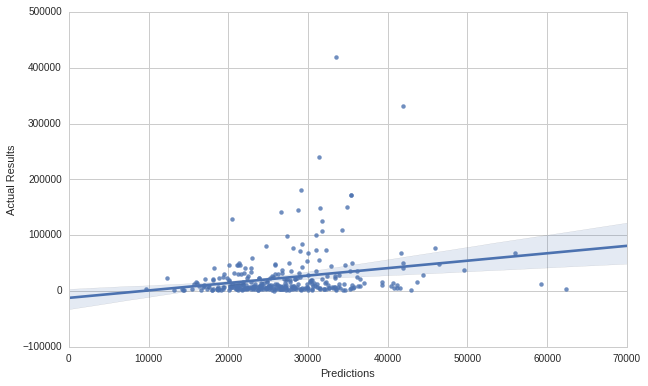

In [256]:
# Plotting 2015 model for our linear regression
sns.set(rc = {"figure.figsize": (10, 6)}, style = 'whitegrid')
ax = sns.regplot(x = lrpred, y = lractual)

ax.set(xlabel = 'Predictions', ylabel = 'Actual Results')

plt.show()

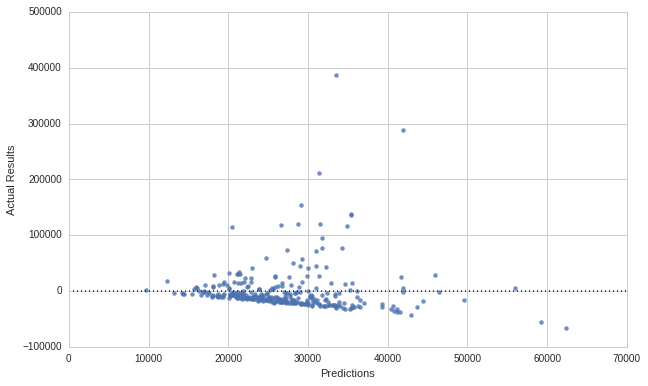

In [257]:
# Plotting the residuals for our linear regression
sns.set(rc = {"figure.figsize": (10, 6)}, style = 'whitegrid')
ax = sns.residplot(x = lrpred, y = lractual)

ax.set(xlabel = 'Predictions', ylabel = 'Actual Results')

plt.show()

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.